# Neo4j contributors prediction

The goal of our project is to determine whether a given GitHub user within our graph contributed to a repository owned by the Neo4j organiszation.

Remember our graph schema is the following:


_NB_ : Some helper functions not relevant to this notebook are located into the [`utils.py`](utils.py) file

In [1]:
# plotting packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# dataframe management
import pandas as pd

# neo4j connection
from neo4j import GraphDatabase

# data science pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# utils
from utils import (
    create_projected_graph,
    run_wcc_algorithm,
    run_louvain_algorithm,
    run_pageRank_algorithm,
    drop_projected_graph,
)

In [2]:
# increase default fig and font size for matplotlib
plt.rcParams["figure.figsize"] = (15, 8)
plt.rcParams["font.size"] = 14

## Computing graph-based features


In [3]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "<YOUR_PASSWORD>"))

In [4]:
# creating the projected graph
create_projected_graph(
    driver,
    "graph",
    node_projection="User",
    relationship_projection={
        "FOLLOWS": {
            "type": "FOLLOWS",
            "orientation": "UNDIRECTED",
        },
    }
)

In [5]:
run_wcc_algorithm(driver, "graph", {"writeProperty": "wcc"})

In [6]:
with driver.session() as session:
    result = session.run("MATCH (u:User) RETURN u.wcc as wcc, u.contributed_to_neo4j as contributed_to_neo4j, count(u) as c ORDER BY c DESC")
    df = pd.DataFrame.from_records(result.data())
    df.head()

,wcc,contributed_to_neo4j,c
0,1,False,396
1,1,True,42
2,30,False,30
3,0,False,1
4,30,True,1


In [7]:
max_wcc = df.iloc[0].wcc
max_wcc

1

In [8]:
# creating the projected graph
create_projected_graph(
    driver,
    "graph_wcc",
    node_projection=f"MATCH (u:User) WHERE u.wcc = {max_wcc} RETURN id(u) as id",
    relationship_projection=f"MATCH (u:User {{wcc: {max_wcc} }})-[:FOLLOWS]-(v:User) RETURN DISTINCT id(u) as source, id(v) as target",
    is_cypher=True
)

### Running graph algorithms on this projected graph

In [9]:
# running the Louvain algorithm on this graph
run_louvain_algorithm(driver, "graph", {"writeProperty": "lv"})

In [10]:
# here, you can run any other type of algorithms, for instance a centrality algorithm like PageRank
run_pageRank_algorithm(driver, "graph_wcc", {"writeProperty": "pr"})

In [11]:
# drop both projected graphs
drop_projected_graph(driver, "graph")
drop_projected_graph(driver, "graph_wcc")

## Fetching the data

In [12]:
query = """
MATCH (u:User)
RETURN  id(u) as user_id, 
        toInteger(u.followers) as followers, 
        toInteger(u.publicRepos) as publicRepos,
        toBoolean(u.contributed_to_neo4j) as contributed_to_neo4j,
        u.pr as pr,
        u.wcc as wcc,
        u.lv as lv
ORDER BY user_id
"""

In [13]:
with driver.session() as session:
    result = session.run(query)

    data = pd.DataFrame.from_records(result.data())

In [14]:
data.describe()

,user_id,followers,publicRepos,pr,wcc,lv
count,596.000000,594.000000,594.000000,438.000000,596.000000,596.000000
mean,297.500000,93.457912,90.321549,0.967055,114.870805,220.699664
std,172.194657,525.309949,547.851252,1.983044,217.157779,217.776693
min,0.000000,0.000000,0.000000,0.367022,0.000000,0.000000
25%,148.750000,5.000000,11.000000,0.431901,1.000000,23.000000
50%,297.500000,21.000000,28.000000,0.466904,1.000000,37.000000
75%,446.250000,61.750000,63.750000,0.502483,30.000000,469.000000
max,595.000000,11644.000000,12670.000000,14.709171,595.000000,595.000000


In [15]:
data.contributed_to_neo4j.value_counts()

False    427
True     169
Name: contributed_to_neo4j, dtype: int64

In [16]:
# cleaning
data["followers"] = data.followers.clip(upper=100)
data["publicRepos"] = data.publicRepos.clip(upper=100)

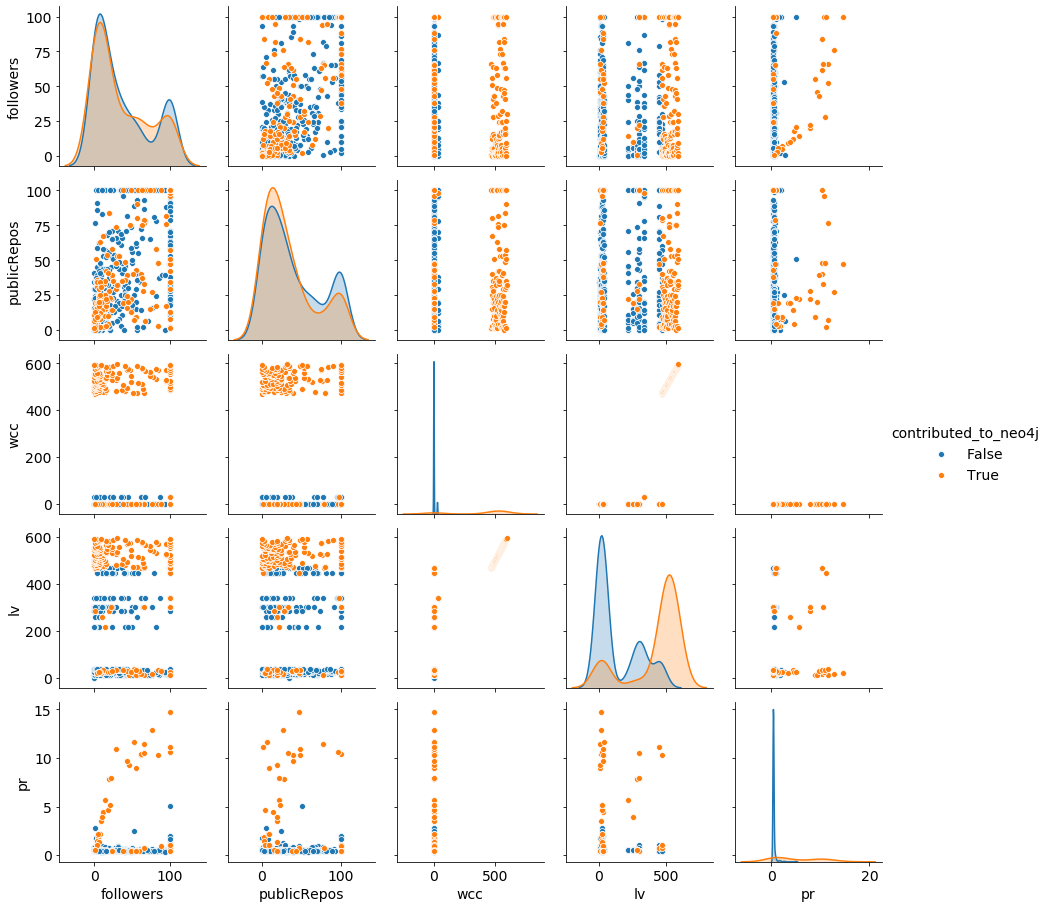

In [17]:
sns.pairplot(data, hue="contributed_to_neo4j", vars=("followers", "publicRepos", "wcc", "lv", "pr"));

## Building the model using WCC feature

In [18]:
len(data.wcc.unique())

129

In [19]:
wcc_community_distribution = data.wcc.value_counts().sort_values(ascending=False)
wcc_keep = sorted(wcc_community_distribution [ wcc_community_distribution > 1].index)
len(wcc_keep)

2

In [20]:
features = ["followers", "publicRepos", "wcc", "pr"]
y = data.contributed_to_neo4j
X = data[features]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, 
    random_state=123,
    # make sure the class balance is preserved
    stratify=y
)
len(X_train), len(X_test)

(417, 179)

In [22]:
pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(categories=[wcc_keep], handle_unknown="ignore"), ["wcc",]),
        (SimpleImputer(strategy="mean"), ["publicRepos", "followers"]),
        # remainder='passthrough'
    ),
    DecisionTreeClassifier(random_state=123, min_samples_leaf=10)
)

new_features = [f"wcc_{k}" for k in wcc_keep] + ["publicRepos", "followers"]

In [23]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[[1,
                                                                             30]],
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['wcc']),
                                                 ('simpleimputer',
                                                  SimpleImpute

In [24]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred,))

              precision    recall  f1-score   support

       False       0.85      1.00      0.92       128
        True       1.00      0.57      0.72        51

    accuracy                           0.88       179
   macro avg       0.93      0.78      0.82       179
weighted avg       0.90      0.88      0.87       179



In [25]:
confusion_matrix(y_test, y_pred)

array([[128,   0],
       [ 22,  29]])

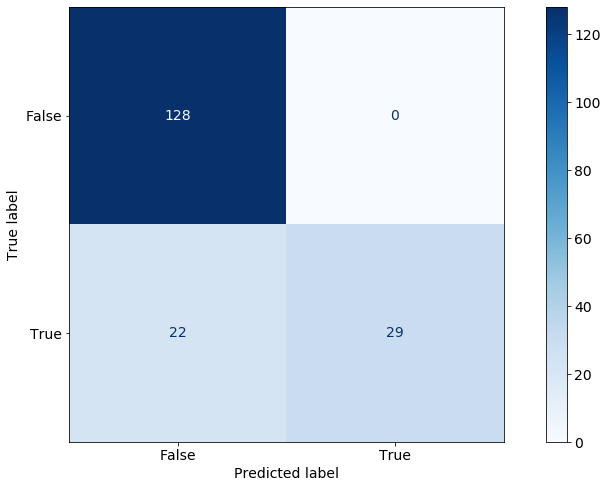

In [26]:
plot_confusion_matrix(
    pipeline, X_test, y_test,
    display_labels=[False, True],
    cmap=plt.cm.Blues,
    normalize=None,
    values_format="d"
);

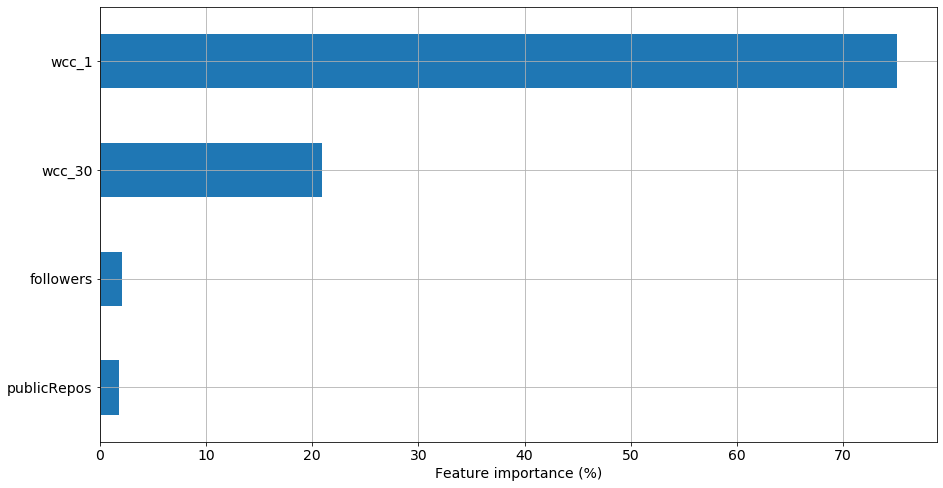

In [27]:
fi = pipeline.named_steps["decisiontreeclassifier"].feature_importances_ * 100

feat_importances = pd.Series(fi, index=new_features)
feat_importances.nlargest(5).sort_values(ascending=True).plot(kind='barh')
plt.xlabel("Feature importance (%)")
plt.grid()
plt.show()

## Building a model using Louvain and PageRank results

In [28]:
lv_community_distribution = data.lv.value_counts().sort_values(ascending=False)
lv_keep = sorted(lv_community_distribution [ lv_community_distribution > 1].index)
len(lv_keep), lv_keep[:10]

(17, [11, 15, 16, 18, 23, 25, 29, 31, 33, 37])

In [29]:
pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(categories=[lv_keep], handle_unknown="ignore"), ["lv",]),
        (OneHotEncoder(categories=[wcc_keep], handle_unknown="ignore"), ["wcc",]),
        (SimpleImputer(strategy="mean"), ["publicRepos", "followers"]),
        (SimpleImputer(strategy="constant", fill_value=0), ["pr"]),
        # remainder='passthrough'
    ),
    DecisionTreeClassifier(random_state=123, min_samples_leaf=10)
)

new_features = [f"lv_{k}" for k in lv_keep] + [f"wcc_{k}" for k in wcc_keep] + ["publicRepos", "followers", "pr"]

In [30]:
features = ["followers", "publicRepos", "wcc", "lv", "pr"]
y = data.contributed_to_neo4j
X = data[features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, 
    random_state=123,
    # make sure the class balance is preserved
    stratify=y
)
len(X_train), len(X_test)

(417, 179)

In [31]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder-1',
                                                  OneHotEncoder(categories=[[11,
                                                                             15,
                                                                             16,
                                                                             18,
                                                                             23,
                                                                             25,
                                                                             29,
                                                                             31,
                                       

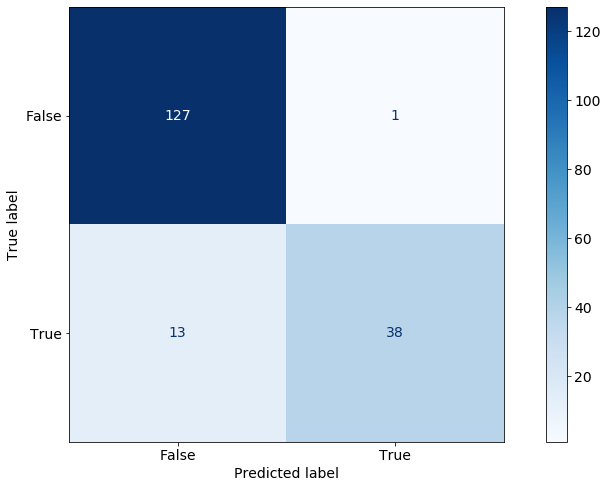

In [32]:
plot_confusion_matrix(
    pipeline, X_test, y_test,
    display_labels=[False, True],
    cmap=plt.cm.Blues,
    normalize=None,
    values_format="d"
);

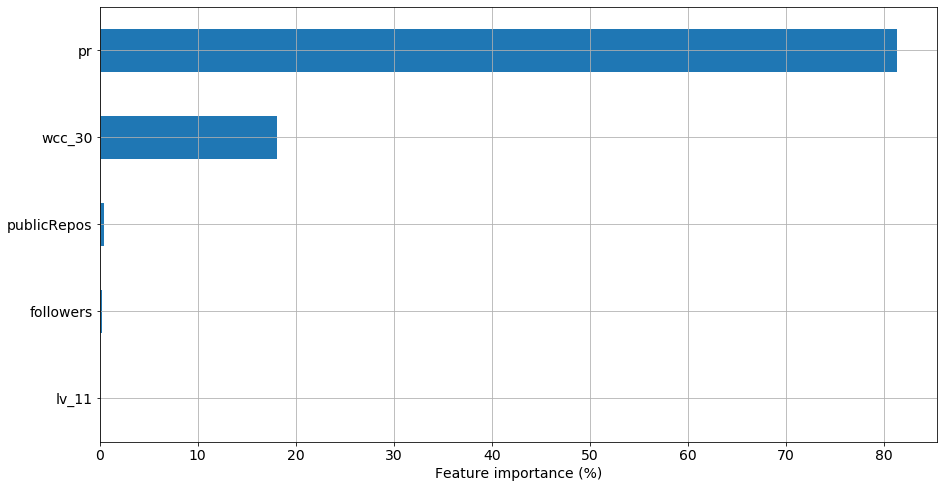

In [33]:
fi = pipeline.named_steps["decisiontreeclassifier"].feature_importances_ * 100

feat_importances = pd.Series(fi, index=new_features)
feat_importances.nlargest(5).sort_values(ascending=True).plot(kind='barh')
plt.xlabel("Feature importance (%)")
plt.grid()
plt.show()